In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def process_image(imagename,resultname,params = "--edge-thresh 10 --peak-thresh 5"):
    """处理一幅图像，然后将结果保存。将图像格式转化为灰度.pgm
    --edge-thresh 10 --peak-thresh 5"""
    
    if imagename[-3:] != 'pgm':
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'
        
    print(imagename)
    cmmd = str("sift "+imagename+" --output="+resultname+"  "+params)
    os.system(cmmd)
    print('processed',imagename,'to',resultname)

In [3]:
def read_features_from_file(filename):
    """读取特征属性值，然后将其以矩阵形式返回"""
    
    f = np.loadtxt(filename)
    #print(f)
    return f[:,:4],f[:,4:]

In [4]:
def write_features_to_file(filename,locs,desc):
    """将特征位置和描述子保存到文件中"""
    
    np.savetxt(filename,hstack((locs,desc)))

In [5]:
def plot_features(im,locs,circle=False):
    """显示带有特征的图像
    输入：im(数组图像),locs(每个特征的行、列、尺度和朝向)"""
    
    def draw_circle(c,r):
        t = np.arange(0,1.01,.01)*2*math.pi
        #print(t.shape)
        x = r*np.cos(t) + c[0]
        y = r*np.sin(t) + c[1]
        plt.plot(x,y,'b',linewidth=2)
        
    plt.imshow(im)
    if(circle):
        for p in locs:
            draw_circle(p[:2],p[2])
    else:
        plt.plot(locs[:,0],locs[:,1],'ob')
            
    #plt.axis('off')
             

In [6]:
def match(desc1,desc2):
    """对于第一幅图像中的每个描述子，选取其在第二个图像中的匹配"""
    
    desc1 = np.array([d/np.linalg.norm(d) for d in desc1])
    desc2 = np.array([d/np.linalg.norm(d) for d in desc2])
    
    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = np.zeros((desc1_size[0],1),'int')
    desc2t = desc2.T
    
    for i in range(desc1_size[0]):
        dotprods = np.dot(desc1[i,:],desc2t)
        dotprods = 0.999*dotprods
        #反余弦和反排序，返回第二幅图像中特征的索引
        indx = np.argsort(np.arccos(dotprods))
        
        #检查最近邻的角度是否小于dist_ratio乘以第二近邻的角度
        if np.arccos(dotprods)[indx[0]] < dist_ratio * np.arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    
    return matchscores

In [7]:
def match_twosided(desc1,desc2,threshold = 0.5):
    """两边对称版本的match()"""
    
    matches_12 = match(desc1,desc2)
    #print(matches_12.shape)
    matches_21 = match(desc2,desc1)
    
    ndx_12  = np.where(matches_12 >= 0)[0]
    
    #去除非对称的匹配
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
            
    return matches_12

In [8]:
imname1 = 'climbing_1_small.jpg'
im1 = np.array(Image.open(imname1).convert('L'))
process_image(imname1,'climbing_1_small.sift')
l1,d1 = read_features_from_file('climbing_1_small.sift')

imname2 = 'climbing_2_small.jpg'
im2 = np.array(Image.open(imname2).convert('L'))
process_image(imname2,'climbing_2_small.sift')
l2,d2 = read_features_from_file('climbing_2_small.sift')

tmp.pgm
processed tmp.pgm to climbing_1_small.sift
tmp.pgm
processed tmp.pgm to climbing_2_small.sift


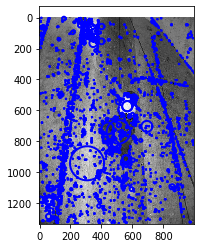

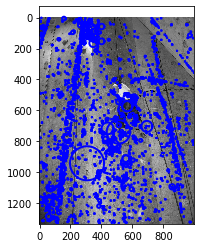

In [74]:
plt.figure()
plt.gray()
plot_features(im1,l1,circle=True)
plt.show()
plot_features(im2,l1,circle=True)
plt.show()

(1333, 1000)


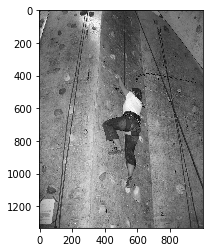

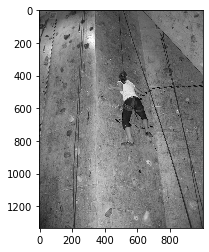

In [9]:
print(im1.shape)
plt.figure()
plt.gray()
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()

In [10]:
def appendimages(im1,im2):
    """返回将两幅图像并排拼接成的一幅新图像"""
    
    #选取具有最少行数的图像，然后填充足够的空行
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1]))),axis = 0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1]))),axis = 0)
        
    return np.concatenate((im1,im2),axis=1)

In [11]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """显示一幅带有连接匹配之间连线的图片
       输入：im1,im2（数组图像），locs1，locs2（特征位置），matchscores（match()的输出），
       show_below（如果图像应该显示在匹配的下方）"""
    
    im3 = appendimages(im1,im2)

    if show_below:
        im3 = np.vstack((im3,im3))
    
    plt.imshow(im3)
    
    cols1 = im1.shape[1]
    print('cols1=',cols1)
    
    temp = []
    
    for i,m in enumerate(matchscores):
        if m > 0:
            plt.plot([locs1[i][0],locs2[m][0]+cols1],[locs1[i][1],locs2[m][1]],'c')
    
    #plt.axis('off')

cols1= 1000


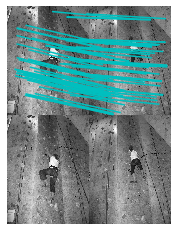

In [14]:
matches = match_twosided(d1,d2).T.squeeze()

plt.figure()
plt.gray()
plot_matches(im1,im2,l1[:,0:2],l2[:,0:2],matches)
#im = appendimages(im1,im2)
#plt.imshow(im)
plt.axis('off')
plt.show()

In [13]:
print(l1.shape)
t = l1[:,0:2]
print(t.shape)
print(t.max(axis = 0))
print()
print(l2.shape)
t = l1[:,0:2]
print(t.shape)
print(t.max(axis = 0))

(2876, 4)
(2876, 2)
[ 997.015 1330.52 ]

(2296, 4)
(2876, 2)
[ 997.015 1330.52 ]


In [36]:
print(matches.T.squeeze().shape)

(2876,)
